In [2]:
%cd /home/ubuntu/statefarm
from theano.sandbox import cuda
cuda.use('gpu0')
%matplotlib inline
from __future__ import print_function, division
path = "/home/ubuntu/statefarm/"
#path = '/home/ubuntu/statefarm/sample/'
import utils; reload(utils)
from utils import *
from IPython.display import FileLink

import skimage
from skimage import exposure, io
#import cv2
import glob
import matplotlib.image as mpimg
#from imutils.object_detection import non_max_suppression

/home/ubuntu/statefarm


Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


# First, make the validation set with *different* drivers

In [3]:
%%bash
cut -f 1 -d ',' driver_imgs_list.csv | grep -v subject | uniq -c
lines=$(expr `wc -l driver_imgs_list.csv | cut -f 1 -d ' '` - 1)
echo "Got ${lines} pics"

    725 p002
    823 p012
    876 p014
    875 p015
   1078 p016
   1237 p021
   1233 p022
   1226 p024
   1196 p026
    848 p035
    651 p039
    605 p041
    591 p042
    724 p045
    835 p047
   1011 p049
    790 p050
    920 p051
    740 p052
    794 p056
    809 p061
    820 p064
   1034 p066
    346 p072
    814 p075
    823 p081
Got 22424 pics


fastai's statefarm has 3478 pics in validation set and 18946 in training, so let's get something close to that

In [4]:
import csv
import os
to_get = set(['p081','p075', 'p072', 'p066', 'p064'])
with open('driver_imgs_list.csv') as f:
    next(f)
    for line in csv.reader(f):
        if line[0] in to_get:
            if os.path.exists('train/%s/%s' %(line[1], line[2])):
                os.popen('mv train/%s/%s valid/%s/%s'%(line[1], line[2], line[1], line[2]))

import glob
print('Training has', len(glob.glob('train/*/*jpg')))
print('Validation has', len(glob.glob('valid/*/*jpg')))

Training has 18587
Validation has 3837


# now starts the actual work

In [5]:
batch_size = 64

gen_t = image.ImageDataGenerator(rotation_range=15, height_shift_range=0.05, 
                shear_range=0.1, channel_shift_range=20, width_shift_range=0.1)

trn_batches = get_batches(path+'train', gen_t, batch_size=batch_size)
val_batches = get_batches(path+'valid', batch_size=batch_size*2, shuffle=False)

Found 18587 images belonging to 10 classes.
Found 3837 images belonging to 10 classes.


In [6]:
from vgg16bn import Vgg16BN
model = vgg_ft_bn(10)

In [7]:
model.compile(optimizer=Adam(1e-3),
       loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
model.fit_generator(trn_batches, trn_batches.N, nb_epoch=3, validation_data=val_batches, 
                 nb_val_samples=val_batches.N)

Epoch 1/3
18587/18587 [==============================] - 556s - loss: 2.9649 - acc: 0.4286 - val_loss: 3.0638 - val_acc: 0.3797
Epoch 2/3
18587/18587 [==============================] - 558s - loss: 1.9663 - acc: 0.5787 - val_loss: 2.9769 - val_acc: 0.4193
Epoch 3/3
18587/18587 [==============================] - 557s - loss: 1.8001 - acc: 0.6075 - val_loss: 3.0384 - val_acc: 0.4277


In [9]:
model.optimizer.lr = 1e-5
model.fit_generator(trn_batches, trn_batches.N, nb_epoch=3, validation_data=val_batches, 
                 nb_val_samples=val_batches.N)

Epoch 1/3
18587/18587 [==============================] - 548s - loss: 1.7652 - acc: 0.6239 - val_loss: 3.4739 - val_acc: 0.4446
Epoch 2/3
18587/18587 [==============================] - 544s - loss: 1.7735 - acc: 0.6368 - val_loss: 3.7832 - val_acc: 0.4279
Epoch 3/3
18587/18587 [==============================] - 543s - loss: 1.7729 - acc: 0.6399 - val_loss: 3.9534 - val_acc: 0.4154


In [10]:
last_conv_idx = [i for i,l in enumerate(model.layers) if type(l) is Convolution2D][-1]
conv_layers = model.layers[:last_conv_idx+1]

In [11]:
conv_model = Sequential(conv_layers)

In [12]:
trn_batches = get_batches(path+'train', gen_t, batch_size=batch_size, shuffle=False)

conv_feat = conv_model.predict_generator(trn_batches, trn_batches.nb_sample)
conv_val_feat = conv_model.predict_generator(val_batches, val_batches.nb_sample)


Found 18587 images belonging to 10 classes.


In [13]:
save_array(path+'results/conv_val_feat.dat', conv_val_feat)
save_array(path+'results/conv_feat.dat', conv_feat)
#print(type(conv_feat))

conv_feat = load_array(path+'results/conv_feat.dat')
conv_val_feat = load_array(path+'results/conv_val_feat.dat')
print(type(conv_feat))

<type 'numpy.ndarray'>


In [14]:

#print(conv_layers[-1].output_shape)
def get_bn_layers(p):
    return [
        MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
        Flatten(),
        Dropout(p),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(10, activation='softmax')
        ]



In [15]:
p = 0.8

In [16]:
(val_classes, trn_classes, val_labels, trn_labels, 
    val_filenames, filenames, test_filenames) = get_classes(path)


Found 18587 images belonging to 10 classes.
Found 3837 images belonging to 10 classes.
Found 79726 images belonging to 1 classes.


In [17]:
bn_model = Sequential(get_bn_layers(p))
bn_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [18]:
bn_model.fit(conv_feat, trn_labels, batch_size=batch_size, nb_epoch=1, 
             validation_data=(conv_val_feat, val_labels))


Train on 18587 samples, validate on 3837 samples
Epoch 1/1
18587/18587 [==============================] - 11s - loss: 3.1639 - acc: 0.2381 - val_loss: 1.4330 - val_acc: 0.5176


In [19]:
bn_model.optimizer.lr = 1e-7
bn_model.fit(conv_feat, trn_labels, batch_size=batch_size, nb_epoch=7, 
             validation_data=(conv_val_feat, val_labels))

Train on 18587 samples, validate on 3837 samples
Epoch 1/7
18587/18587 [==============================] - 11s - loss: 1.4675 - acc: 0.5147 - val_loss: 1.2066 - val_acc: 0.6161
Epoch 2/7
18587/18587 [==============================] - 11s - loss: 0.9823 - acc: 0.6595 - val_loss: 1.2035 - val_acc: 0.6224
Epoch 3/7
18587/18587 [==============================] - 11s - loss: 0.7936 - acc: 0.7255 - val_loss: 1.2357 - val_acc: 0.6046
Epoch 4/7
18587/18587 [==============================] - 10s - loss: 0.6630 - acc: 0.7732 - val_loss: 1.0442 - val_acc: 0.6729
Epoch 5/7
18587/18587 [==============================] - 11s - loss: 0.5988 - acc: 0.7995 - val_loss: 1.0698 - val_acc: 0.6643
Epoch 6/7
18587/18587 [==============================] - 10s - loss: 0.5507 - acc: 0.8176 - val_loss: 1.0956 - val_acc: 0.6586
Epoch 7/7
18587/18587 [==============================] - 10s - loss: 0.4997 - acc: 0.8299 - val_loss: 1.1512 - val_acc: 0.6529


# Let's predict on the test set

The following is mashed together from fast.ai

In [20]:
test_batches = get_batches(path+'test', batch_size=batch_size, shuffle=False, class_mode=None)

Found 79726 images belonging to 1 classes.


In [21]:
conv_test_feat = conv_model.predict_generator(test_batches, test_batches.nb_sample)


That took *forever* (one hour? didn't time it perfectly)

In [22]:
preds = bn_model.predict(conv_test_feat, batch_size=batch_size*2)
subm = do_clip(preds,0.93)

In [23]:
subm_name = path+'results/subm.gz'

In [24]:
classes = sorted(trn_batches.class_indices, key=trn_batches.class_indices.get)

In [25]:
submission = pd.DataFrame(subm, columns=classes)
submission.insert(0, 'img', [a[4:] for a in test_filenames])
submission.head()
submission.to_csv(subm_name, index=False, compression='gzip')

In [26]:
from IPython.display import FileLink
FileLink(subm_name)

/home/ubuntu/statefarm/results/subm.gz

# Private score: 0.94359
# Public score: 1.18213


In [27]:
bn_model.save_weights(path+'models/bn_model.h5')
bn_model.load_weights(path+'models/bn_model.h5')

In [28]:
bn_feat = bn_model.predict(conv_feat, batch_size=batch_size)
bn_val_feat = bn_model.predict(conv_val_feat, batch_size=batch_size)

Let's try something else - can I look at what the model predicts for the training set?

Let's have a look at the images with a 'bad' maximum probability, around 50% - 
how many training pictures do we have with bad probabilities?

In [29]:
np.max(bn_feat[:,1])

0.99996793

Give me all training pictures that don't have a class 'probability' above 90%

In [30]:
np.where(np.amax(bn_feat, axis=1) < 0.9)

(array([    1,    11,    16, ..., 18577, 18582, 18583]),)

In [53]:
def check_training_picture(bn_feat, filenames, number):
    print(bn_feat[number,:])
    print(filenames[number])
    plt.imshow(mpimg.imread('train/' + filenames[number]))

[ 0.5061  0.0131  0.0147  0.0492  0.0204  0.0084  0.3025  0.0023  0.0652  0.0181]
c0/img_101091.jpg


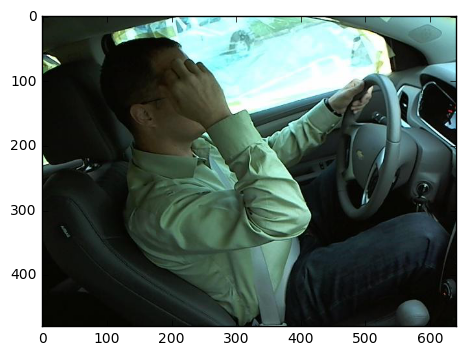

In [54]:
check_training_picture(bn_feat, filenames, 22)

This is marked as class0 - 

```
c0: normal driving
c1: texting - right
c2: talking on the phone - right
c3: texting - left
c4: talking on the phone - left
c5: operating the radio
c6: drinking
c7: reaching behind
c8: hair and makeup
c9: talking to passenger
```

That hand is probably confusing, but it's mostly the correct class.

[  5.4387e-01   9.9393e-04   6.4095e-06   3.1461e-05   3.1368e-04   1.3539e-03   3.0034e-05
   6.8933e-04   7.3784e-05   4.5264e-01]
c0/img_102087.jpg


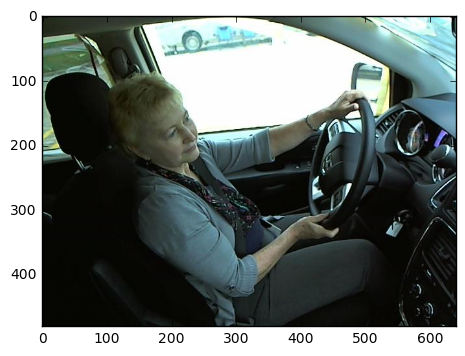

In [55]:
check_training_picture(bn_feat, filenames, 45)

This doesn't have any 'good' class, everything is low, which is weird - could be the not-straight head angle, but who knows. I just realised that some pictures have a blue tape-like thing on the driver window (see above and below), some pictures don't have that sheet, which is probably confusing.

# TODO: find a way to mask that window

[  1.4622e-01   1.4535e-03   1.7558e-05   1.5187e-04   7.7130e-05   3.3243e-03   9.7658e-06
   2.4722e-04   4.6495e-04   8.4804e-01]
c9/img_39396.jpg


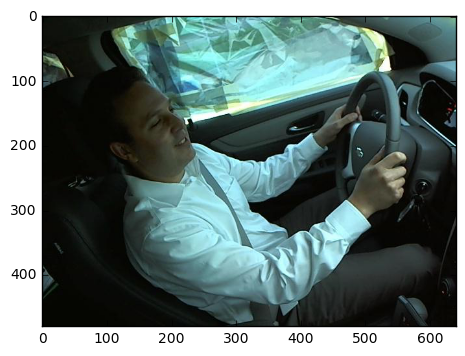

In [56]:
check_training_picture(bn_feat, filenames, 17421)

This is marked as 'talking to passenger', but it may as well be c0, driving normally.

# Kick out the 'bad' pictures
I believe that these low quality marks 'confuse' the network, so a network trained without those pictures should work slightly better.

In [32]:
to_remove = np.where(np.amax(bn_feat, axis=1) < 0.9)[0]
print(len(to_remove))
print(1580./18587*100)

1580
8.50056491096


1580 pictures are 'weird', which is not that much compared to our 18587 pictures (roughly 8.5%)

In [38]:
to_remove_files = set([filenames[index] for index in to_remove])
list(to_remove_files)[:5]

out = open('weird_files.txt', 'w')
for f in to_remove_files:
    out.write('%s\n'%f)

In [5]:
print(path)
%pwd

to_remove_files = [x.rstrip() for x in open('/home/ubuntu/statefarm/train/weird_files.txt')]
len(to_remove_files)
to_remove_files[:5]

/home/ubuntu/statefarm/


['c4/img_41361.jpg',
 'c8/img_51539.jpg',
 'c0/img_87801.jpg',
 'c4/img_10249.jpg',
 'c4/img_87180.jpg']

In [4]:
%%bash
mkdir weird_ones
mkdir weird_ones/train
for i in {0..9}; do mkdir /home/ubuntu/statefarm/weird_ones/train/c${i}; done


mkdir: cannot create directory ‘weird_ones’: File exists
mkdir: cannot create directory ‘weird_ones/train’: File exists
mkdir: cannot create directory ‘/home/ubuntu/statefarm/weird_ones/train/c0’: File exists
mkdir: cannot create directory ‘/home/ubuntu/statefarm/weird_ones/train/c1’: File exists
mkdir: cannot create directory ‘/home/ubuntu/statefarm/weird_ones/train/c2’: File exists
mkdir: cannot create directory ‘/home/ubuntu/statefarm/weird_ones/train/c3’: File exists
mkdir: cannot create directory ‘/home/ubuntu/statefarm/weird_ones/train/c4’: File exists
mkdir: cannot create directory ‘/home/ubuntu/statefarm/weird_ones/train/c5’: File exists
mkdir: cannot create directory ‘/home/ubuntu/statefarm/weird_ones/train/c6’: File exists
mkdir: cannot create directory ‘/home/ubuntu/statefarm/weird_ones/train/c7’: File exists
mkdir: cannot create directory ‘/home/ubuntu/statefarm/weird_ones/train/c8’: File exists
mkdir: cannot create directory ‘/home/ubuntu/statefarm/weird_ones/train/c9’: Fi

In [13]:
%cd /home/ubuntu/statefarm/train
for l in glob.glob('*/*jpg'):
    if l in to_remove_files:
        os.popen('mv %s ../weird_ones/train/%s'%(l, l))

/home/ubuntu/statefarm/train


In [14]:
%%bash
find . -type f | wc -l

17008


OK we removed the weird ones.

In [15]:
path = "/home/ubuntu/statefarm/"


In [16]:
batch_size = 64

gen_t = image.ImageDataGenerator(rotation_range=15, height_shift_range=0.05, 
                shear_range=0.1, channel_shift_range=20, width_shift_range=0.1)

trn_batches = get_batches(path+'train', gen_t, batch_size=batch_size)
val_batches = get_batches(path+'valid', batch_size=batch_size*2, shuffle=False)

Found 17007 images belonging to 10 classes.
Found 3837 images belonging to 10 classes.


In [17]:
from vgg16bn import Vgg16BN
model = vgg_ft_bn(10)

In [18]:
model.compile(optimizer=Adam(1e-3),
       loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
model.fit_generator(trn_batches, trn_batches.N, nb_epoch=3, validation_data=val_batches, 
                 nb_val_samples=val_batches.N)

Epoch 1/3
17007/17007 [==============================] - 504s - loss: 2.8008 - acc: 0.4544 - val_loss: 3.0788 - val_acc: 0.4042
Epoch 2/3
17007/17007 [==============================] - 514s - loss: 1.8587 - acc: 0.5992 - val_loss: 3.4269 - val_acc: 0.3774
Epoch 3/3
17007/17007 [==============================] - 518s - loss: 1.6381 - acc: 0.6416 - val_loss: 3.3901 - val_acc: 0.3977


In [20]:
model.optimizer.lr = 1e-5
model.fit_generator(trn_batches, trn_batches.N, nb_epoch=3, validation_data=val_batches, 
                 nb_val_samples=val_batches.N)

Epoch 1/3
17007/17007 [==============================] - 519s - loss: 1.5947 - acc: 0.6538 - val_loss: 3.3720 - val_acc: 0.4522
Epoch 2/3
17007/17007 [==============================] - 518s - loss: 1.5708 - acc: 0.6681 - val_loss: 3.4160 - val_acc: 0.4339
Epoch 3/3
17007/17007 [==============================] - 515s - loss: 1.6429 - acc: 0.6689 - val_loss: 4.0929 - val_acc: 0.3912


In [21]:
last_conv_idx = [i for i,l in enumerate(model.layers) if type(l) is Convolution2D][-1]
conv_layers = model.layers[:last_conv_idx+1]

In [22]:
conv_model = Sequential(conv_layers)

In [23]:
trn_batches = get_batches(path+'train', gen_t, batch_size=batch_size, shuffle=False)

conv_feat = conv_model.predict_generator(trn_batches, trn_batches.nb_sample)
conv_val_feat = conv_model.predict_generator(val_batches, val_batches.nb_sample)


Found 17007 images belonging to 10 classes.


In [24]:

#print(conv_layers[-1].output_shape)
def get_bn_layers(p):
    return [
        MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
        Flatten(),
        Dropout(p),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(10, activation='softmax')
        ]



In [25]:
p = 0.8

In [26]:
(val_classes, trn_classes, val_labels, trn_labels, 
    val_filenames, filenames, test_filenames) = get_classes(path)


Found 17007 images belonging to 10 classes.
Found 3837 images belonging to 10 classes.
Found 79726 images belonging to 1 classes.


In [27]:
bn_model = Sequential(get_bn_layers(p))
bn_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [28]:
bn_model.fit(conv_feat, trn_labels, batch_size=batch_size, nb_epoch=1, 
             validation_data=(conv_val_feat, val_labels))


Train on 17007 samples, validate on 3837 samples
Epoch 1/1
17007/17007 [==============================] - 10s - loss: 3.1612 - acc: 0.2461 - val_loss: 1.4841 - val_acc: 0.4636


In [29]:
bn_model.optimizer.lr = 1e-5
bn_model.fit(conv_feat, trn_labels, batch_size=batch_size, nb_epoch=7, 
             validation_data=(conv_val_feat, val_labels))

Train on 17007 samples, validate on 3837 samples
Epoch 1/7
17007/17007 [==============================] - 10s - loss: 1.3785 - acc: 0.5421 - val_loss: 1.3588 - val_acc: 0.5351
Epoch 2/7
17007/17007 [==============================] - 10s - loss: 0.9063 - acc: 0.6846 - val_loss: 1.2480 - val_acc: 0.5994
Epoch 3/7
17007/17007 [==============================] - 10s - loss: 0.6948 - acc: 0.7599 - val_loss: 1.2294 - val_acc: 0.6237
Epoch 4/7
17007/17007 [==============================] - 10s - loss: 0.5743 - acc: 0.8016 - val_loss: 1.2193 - val_acc: 0.6286
Epoch 5/7
17007/17007 [==============================] - 10s - loss: 0.5032 - acc: 0.8301 - val_loss: 1.2701 - val_acc: 0.6268
Epoch 6/7
17007/17007 [==============================] - 10s - loss: 0.4660 - acc: 0.8380 - val_loss: 1.2784 - val_acc: 0.6213
Epoch 7/7
17007/17007 [==============================] - 10s - loss: 0.4307 - acc: 0.8546 - val_loss: 1.3651 - val_acc: 0.6028


In [30]:
bn_model.optimizer.lr = 1e-7
bn_model.fit(conv_feat, trn_labels, batch_size=batch_size, nb_epoch=7, 
             validation_data=(conv_val_feat, val_labels))

Train on 17007 samples, validate on 3837 samples
Epoch 1/7
17007/17007 [==============================] - 10s - loss: 0.4004 - acc: 0.8684 - val_loss: 1.5176 - val_acc: 0.5968
Epoch 2/7
17007/17007 [==============================] - 10s - loss: 0.3883 - acc: 0.8726 - val_loss: 1.4288 - val_acc: 0.6216
Epoch 3/7
17007/17007 [==============================] - 10s - loss: 0.3537 - acc: 0.8803 - val_loss: 1.3639 - val_acc: 0.6213
Epoch 4/7
17007/17007 [==============================] - 10s - loss: 0.3494 - acc: 0.8837 - val_loss: 1.3312 - val_acc: 0.6375
Epoch 5/7
17007/17007 [==============================] - 10s - loss: 0.3299 - acc: 0.8908 - val_loss: 1.3274 - val_acc: 0.6343
Epoch 6/7
17007/17007 [==============================] - 10s - loss: 0.3047 - acc: 0.9002 - val_loss: 1.2876 - val_acc: 0.6534
Epoch 7/7
17007/17007 [==============================] - 10s - loss: 0.3059 - acc: 0.8999 - val_loss: 1.2306 - val_acc: 0.6664


In [31]:
test_batches = get_batches(path+'test', batch_size=batch_size, shuffle=False, class_mode=None)

Found 79726 images belonging to 1 classes.


In [32]:
conv_test_feat = conv_model.predict_generator(test_batches, test_batches.nb_sample)


That took *forever* (one hour? didn't time it perfectly)

In [33]:
preds = bn_model.predict(conv_test_feat, batch_size=batch_size*2)
subm = do_clip(preds,0.93)

In [34]:
subm_name = path+'results/subm_woweird.gz'

In [35]:
classes = sorted(trn_batches.class_indices, key=trn_batches.class_indices.get)

In [36]:
submission = pd.DataFrame(subm, columns=classes)
submission.insert(0, 'img', [a[4:] for a in test_filenames])
submission.head()
submission.to_csv(subm_name, index=False, compression='gzip')

In [37]:
from IPython.display import FileLink
FileLink(subm_name)

/home/ubuntu/statefarm/results/subm_woweird.gz

# Private score: 0.92506
# Public score:	1.11814

# RESULTS
Interestingly, the validation accuracy and validation loss is VERY similar, almost identical to the above. The training accuracy is slightly better.

# TODO: Fix the validation problems too

# TRYING OUT CUTTING FROM PICTURES

In [45]:
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())
img = glob.glob('train/*/*jpg')[100]

img = cv2.imread(img)

(rects, weights) = hog.detectMultiScale(img, winStride=(4, 4), padding=(8, 8), scale=1.05)
for (x, y, w, h) in rects:
    cv2.rectangle(orig, (x, y), (x + w, y + h), (0, 0, 255), 2)
rects = np.array([[x, y, x + w, y + h] for (x, y, w, h) in rects])
pick = non_max_suppression(rects, probs=None, overlapThresh=0.5)
for (xA, yA, xB, yB) in pick:
    cv2.rectangle(img, (xA, yA), (xB, yB), (0, 255, 0), 2)
#plt.imshow(img)
#cv2.imshow('hi', img)
img.save('test.png')

AttributeError: 'numpy.ndarray' object has no attribute 'save'